### This file consists of CNN method of classification

In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
from librosa import display
import matplotlib
matplotlib.use('agg')
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

### Audio files are converted to melspectograms and stored in a file 

In [2]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = 'clap cough music talking train'.split()
for g in genres:
    pathlib.Path(f'imgdata/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'dataa/{g}'):
        audio = f'dataa/{g}/{filename}'
        y, sr = librosa.load(audio, sr = 22050)
        
        # Compute spectrogram
        M =librosa.feature.melspectrogram(y= y, sr=sr, n_fft=2048, 
                                           hop_length=512)
        
        # Power in DB
        log_power = librosa.power_to_db(M, ref=np.max)# Covert to dB (log) scale
        
        #predefined global max and min for image scaling 
        
        X_max= 0.0
        X_min= -100.0
        
        #Converting log values to array like values
        fmax=np.amax(log_power)
        fmin=np.amin(log_power)
        
        #replacing the max and min values 
        X_max=np.maximum(int(X_max),int(fmax))
        X_min=np.minimum(int(X_min),int(fmin))
    
        ##Normalization process with respect to minimum and maximum values
        db_Melspecgram_min_max = (log_power - X_min)  /  (X_max - X_min)  
        #print("Max and min values:",db_Melspecgram_min_max)
    
        # Plotting the spectrogram and save as JPG without axes (just the image)
        plt.figure(figsize=(5,5))
        plt.axis('off');
        plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
        librosa.display.specshow(db_Melspecgram_min_max, sr=sr, x_axis='time', y_axis='mel')
        #plt.colorbar()
        plt.show()
        plt.savefig(f'imgdata/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

### Data is split into train, test and validation files and stored in another folder

In [3]:
import splitfolders
splitfolders.ratio('./imgdata/', output="./cnnaudio", seed=1337, ratio=(.75, .15, .1)) 

Copying files: 1007 files [00:02, 460.07 files/s]


### Data Augmentation

In [4]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255, # rescale all pixel values from 0-255, so aftre this step all our pixel values are in range (0,1) 
        zoom_range=0.2) #to apply zoom) # image will be flipper horiz
val_datagen = ImageDataGenerator(rescale=1./255)

### Load the dataset

In [5]:
training_set = train_datagen.flow_from_directory(
        './cnnaudio/train',
        target_size=(256, 256),
        color_mode="rgb",
        batch_size=10,
        class_mode='categorical',
        shuffle = True,
        seed=42)
val_set = val_datagen.flow_from_directory(
        './cnnaudio/val',
        target_size=(256, 256),
        color_mode="rgb",
        batch_size=10,
        class_mode='categorical',
        shuffle = False,
        seed=42 )

Found 752 images belonging to 5 classes.
Found 150 images belonging to 5 classes.


### importing libraries for building the model

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #used for rescaling the images
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

### model building using CNN

In [7]:
model=tf.keras.models.Sequential([tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(256,256,3)),
                                 # model.add(Dropout(0.2)),
                                 tf.keras.layers.MaxPool2D(2,2),
                                 tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                 tf.keras.layers.MaxPool2D(2,2), 
                                 tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                                 tf.keras.layers.MaxPool2D(2,2), 
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(128,activation='relu'),
                                 tf.keras.layers.Dense(5,activation='softmax')                       
                                 ])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0

### Compiling the model 

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
             #optimizer=RMSprop(lr=0.001),
             metrics=['accuracy'])

### model training

In [10]:
model_fit=model.fit(training_set,
                   steps_per_epoch=75,
                   epochs=20,
                   validation_data=val_set,
                   validation_steps=15)

Epoch 1/20
75/75 [==============================] - 101s 1s/step - loss: 1.2157 - accuracy: 0.4811 - val_loss: 0.5824 - val_accuracy: 0.7333
Epoch 2/20
75/75 [==============================] - 104s 1s/step - loss: 0.5220 - accuracy: 0.8194 - val_loss: 0.2070 - val_accuracy: 0.9400
Epoch 3/20
75/75 [==============================] - 104s 1s/step - loss: 0.3503 - accuracy: 0.8652 - val_loss: 0.2264 - val_accuracy: 0.9333
Epoch 4/20
75/75 [==============================] - 102s 1s/step - loss: 0.2265 - accuracy: 0.9259 - val_loss: 0.1853 - val_accuracy: 0.9467
Epoch 5/20
75/75 [==============================] - 111s 1s/step - loss: 0.2086 - accuracy: 0.9340 - val_loss: 0.1259 - val_accuracy: 0.9733
Epoch 6/20
75/75 [==============================] - 110s 1s/step - loss: 0.1518 - accuracy: 0.9555 - val_loss: 0.1437 - val_accuracy: 0.9600
Epoch 7/20
75/75 [==============================] - 108s 1s/step - loss: 0.0905 - accuracy: 0.9663 - val_loss: 0.1007 - val_accuracy: 0.9867
Epoch 8/20
75

### Evaluation of the model by plotting the accuarcy and loss plots

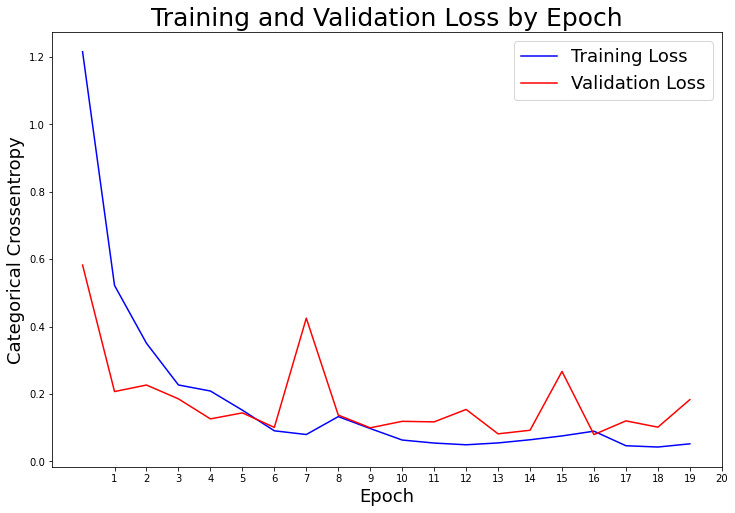

In [32]:
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import numpy as np
%matplotlib inline
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')

# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,21), range(1,21))

plt.legend(fontsize = 18);

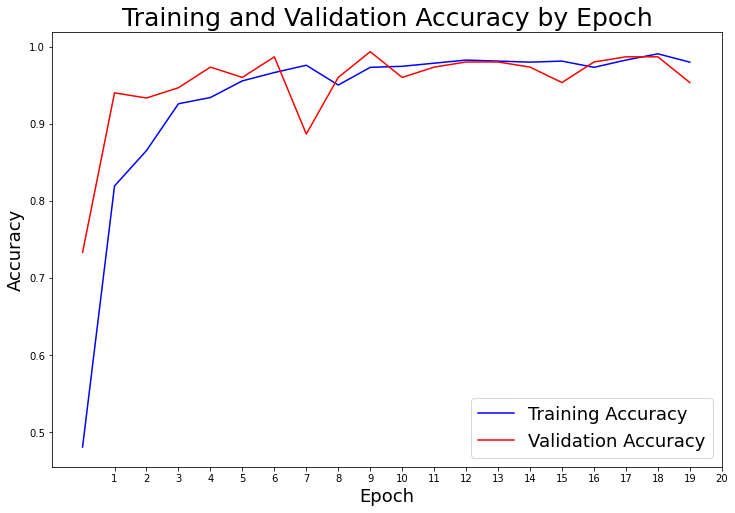

In [33]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train accuracy and test accuracy over epochs.
train_loss = model_fit.history['accuracy']
val_loss = model_fit.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(val_loss, label='Validation Accuracy', color='red')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(1,21), range(1,21))

plt.legend(fontsize = 18);

### save the model for predictions

In [13]:
model.save('cnn_audio.h5') #save the model 

In [19]:
test_set = val_datagen.flow_from_directory(
        './cnnaudio/test',
        target_size=(256, 256),
        color_mode="rgb",
        batch_size=10,
        class_mode='categorical',
        shuffle = False,
        seed=42 )

Found 105 images belonging to 5 classes.


In [22]:
#Model Evaluation
model.evaluate(test_set, steps=10)

10/10 [==============================] - 3s 260ms/step - loss: 0.1538 - accuracy: 0.9500


[0.15375949442386627, 0.949999988079071]

## Model predictions on the dataset

## Confusion Matrix

In [29]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')



Confusion matrix, without normalization


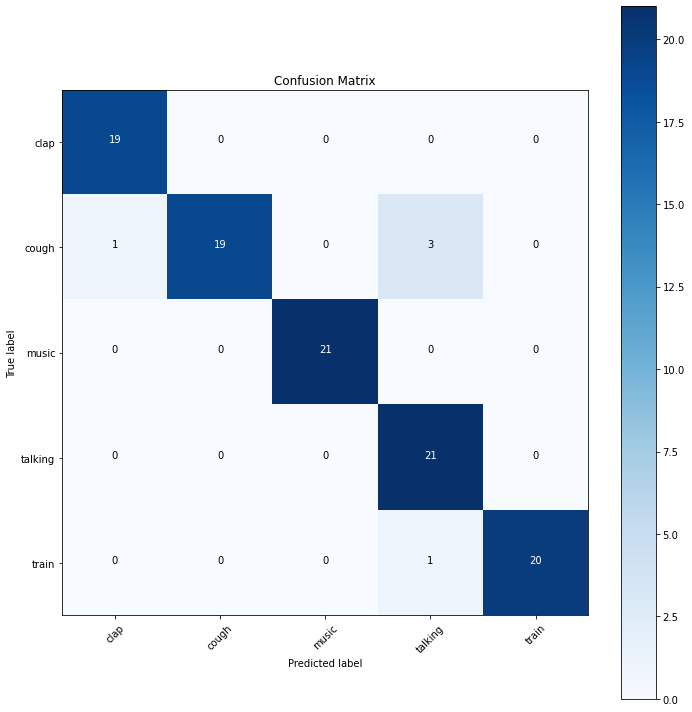

In [31]:
y_pred = model.predict_generator(test_set)

y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_set.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

## saved model is checked for test set

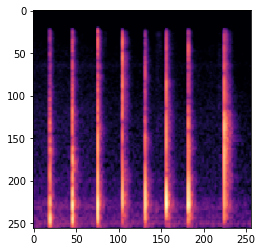

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[0]
the predicted image is clap


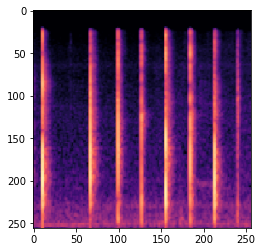

[0]
the predicted image is clap


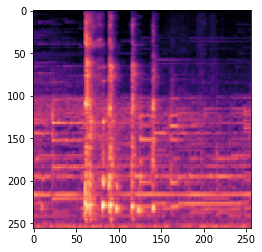

[1]
the predicted image is cough


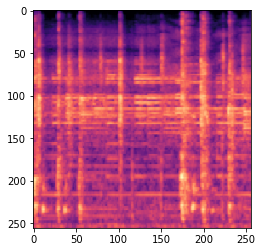

[1]
the predicted image is cough


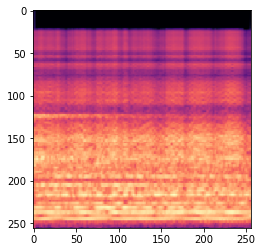

[2]
the predicted image is music


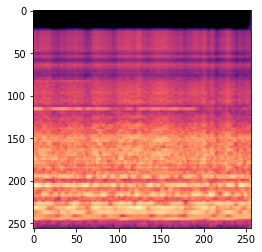

[2]
the predicted image is music


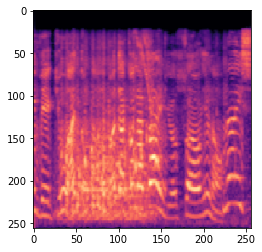

[3]
the predicted image is talking


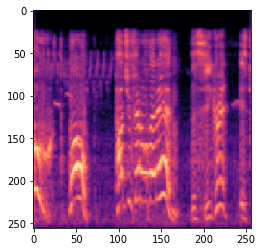

[3]
the predicted image is talking


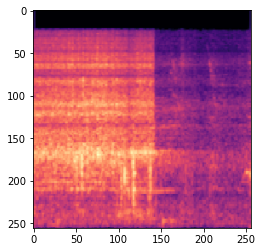

[1]
the predicted image is cough


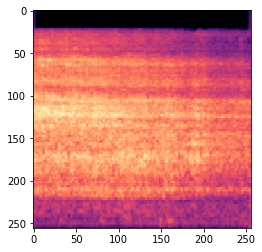

[4]
the predicted image is train


In [17]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
# image folder
folder_path = 'cnnaudio_predict/test/'
# path to model
model_path = 'cnn_audio.h5'
# dimensions of images
img_width, img_height = 256, 256

# load the trained model
model = load_model(model_path)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# load all images into a list
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(img, axis=0)                             
    #images.append(img)

# stack up images list to pass for prediction
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size=10)
    print(classes)
    a = classes
    if a == 0:
        print("the predicted image is clap")
    elif a == 1:
        print("the predicted image is cough")
    elif a == 2:
        print("the predicted image is music")
    elif a == 3:
        print("the predicted image is talking")
    elif a == 4:
        print("the predicted image is train")

In [30]:
target_names = []

for key in training_set.class_indices:

    target_names.append(key)

### The CNN model built here are able to classify the images to a greater extent. However, as the dataset increases the convolution layers must be tuned depending on the complexity of the data

## The model provides an accuracy of 98% which can be termed as a better model for the acquired dataset.